# Computing perspective fields based on from camera parameters
## Read an equirectangular image (in this example reading an exr file)

In [1]:
import numpy as np
import ezexr # read exr file


img_format='RGB'
input_pano = "../assets/imgs/quattro_canti_2k.exr"
data = ezexr.imread(input_pano, rgb=False)
equi_img = np.stack([data['R'], data['G'], data['B']], axis=-1)
equi_img = np.clip(np.power(equi_img, 0.45), 0, 1)
equi_img = np.uint8(equi_img*255)

## Crop the panorama using a pin-hole camera model

In [2]:
from perspective2d.utils.panocam import PanoCam
roll = 0
yaw = 180
pitch = 20
vfov = 70
width = 640
height = 480
rgb = PanoCam.crop_equi(
    equi_img=equi_img, 
    vfov=vfov, 
    im_w=width, 
    im_h=height, 
    azimuth=yaw,
    elevation=pitch, 
    roll=roll, 
    ar=width/height, 
    mode='bilinear'
)

/home/jinlinyi/miniforge3/envs/pfinference/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/jinlinyi/miniforge3/envs/pfinference/lib/python3.9/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1634272204863/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


## Calculate perspective fields based on pin-hole camera parameters

In [3]:
up = PanoCam.get_up(np.radians(vfov), width, height, np.radians(pitch), np.radians(roll))
lati = PanoCam.get_lat(np.radians(vfov), width, height, np.radians(pitch), np.radians(roll))

## Visualize perspective fields

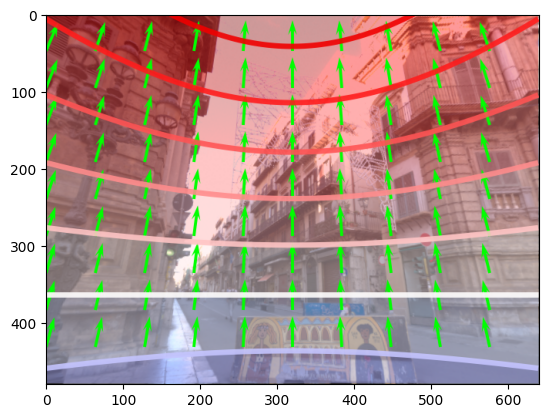

In [4]:
import matplotlib.pyplot as plt
from perspective2d.utils import draw_perspective_fields
blend = draw_perspective_fields(rgb, up, np.radians(lati))
plt.imshow(blend)
plt.show()

# Perspective Fields can be defined on distorted images, we provide an implementation assuming Unified Spherical Model. 
Figure 1 of [DeepCalib paper](https://drive.google.com/file/d/1pZgR3wNS6Mvb87W0ixOHmEVV6tcI8d50/view) gives a good explanation of this camera projection model 

/home/jinlinyi/workspace/test_folder/src/perspective2d/perspective2d/utils/panocam.py:66: RuntimeWarning: invalid value encountered in sqrt
  fmin = np.sqrt(


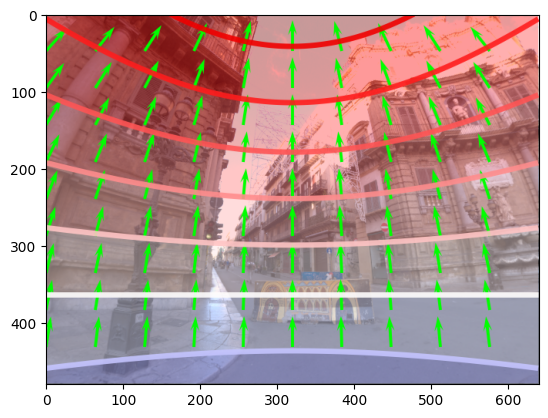

In [5]:
xi = 0.5 # distortion parameter from Unified Spherical Model

x = -np.sin(np.radians(vfov/2))
z = np.sqrt(1 - x**2)
f_px_effective = -0.5*(width/2)*(xi+z)/x
crop, _, _, _, up, lat, xy_map = PanoCam.crop_distortion(equi_img,
                                             f=f_px_effective,
                                             xi=xi,
                                             H=height,
                                             W=width,
                                             az=yaw, # degrees
                                             el=-pitch,
                                             roll=-roll)
blend = draw_perspective_fields(crop, up, np.radians(lati))
plt.imshow(blend)
plt.show()